# 01. PyTorch Workflow Fundamentals

You: have some data + want it modelled.

Let's do that with PyTorch.

How about we start with a straight line?

And we see if we can build a model with PyTorch to predict that straight line.

## TK - What we're going to cover

1. Data (prepare and load)
2. Build model
3. Fitting model to data (training)
4. Making predictions and evaluating a model (inference)
    * Improving a model through experimentations (optional)
5. Saving and loading model
6. Putting it all together



In [1]:
what_were_covering = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt

## TK - Data

Let's create the data as a straight line.

We'll use linear regression to create the data with known parameters and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

TK - the essence of machine learning (and deep learning) is to create model that's able to estimate some function, a function being a way to navigate patterns in data.



In [3]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

# Create data
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [4]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions != None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

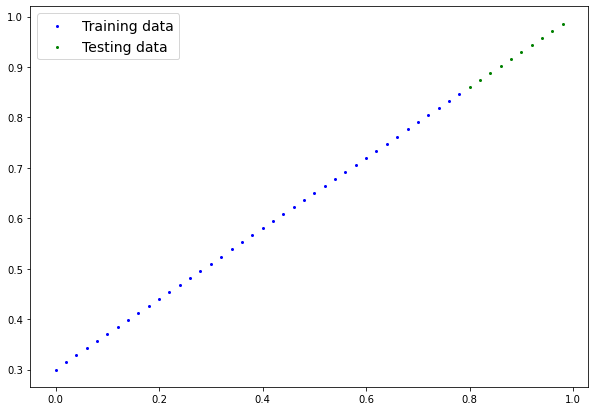

In [6]:
plot_predictions();

## Build model

Now we've got some data, let's build a model to use the blue dots to predict the green dots.

TK - In PyTorch everything to do with models is considered a Module (from nn.Module)... 
* What is `requires_grad=True`?
* What is `nn.Module`?
* What is `forward()`?

In [7]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1,
            requires_grad=True, 
            dtype=torch.float
        ))

        self.bias = nn.Parameter(torch.randn(1, 
            requires_grad=True,
            dtype=torch.float
        ))

    # Forward defines the computation in the model
    def forward(self, x):
        return self.weights * x + self.bias

In [8]:
torch.manual_seed(42)
model_0 = LinearRegressionModel()
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

We want to start from random parameters and get the model to update them towards parameters that fit our data best (the original `weight` and `bias` values).

In [10]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [11]:
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

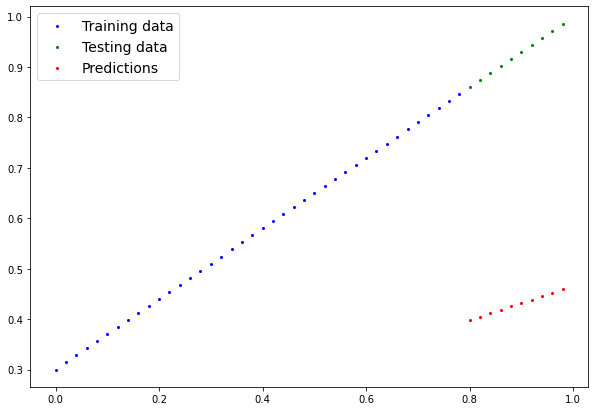

In [12]:
plot_predictions(predictions=y_preds)

## Train model

TK - loss function (show graphic for loss function, MAE is distance between the dot points)

In [13]:
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [14]:
X_test

tensor([[0.8000],
        [0.8200],
        [0.8400],
        [0.8600],
        [0.8800],
        [0.9000],
        [0.9200],
        [0.9400],
        [0.9600],
        [0.9800]])

In [15]:
torch.manual_seed(42)
epochs = 100
for epoch in range(epochs):
    # Training
    # 1. Forward pass on train data
    y_pred = model_0(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    # Testing
    # 1. Forward pass on test data
    with torch.inference_mode():
        test_pred = model_0(X_test)

    # 2. Caculate loss on test data
    test_loss = loss_fn(test_pred, y_test.type(torch.float))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


TK - Let's see how close our model gets to the original values for weights and bias
* This is the whole idea of machine learning and deep learning - there are some ideal values that describe our data, can we train a model to figure them out programmatically...

In [16]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [17]:
weight, bias

(0.7, 0.3)

## TK - Making predictions

Notes: 
* When making predictions or using model in inference mode, use `model.eval()`
* When making predictions, use `with torch.inference_mode():` context manager
* All predictions and calculations should be made on same device (e.g. on GPU or on CPU only)

In [18]:
model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

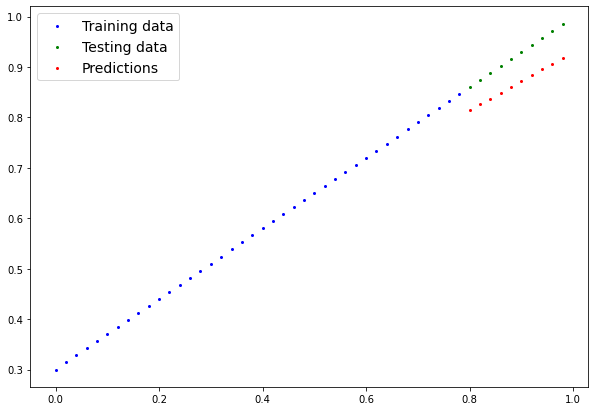

In [19]:
plot_predictions(predictions=y_preds)

## TK 5. Saving and loading a model

See here for more: https://pytorch.org/tutorials/beginner/saving_loading_models.html

* 3 core functions to be aware of when saving and loading models in PyTorch:
    1. torch.save - Saves a serialized object to disk. This function uses Python's pickle utility for serialization. Models, tensors and dictionaries of all kinds of objects can be saved using this function.
    2. torch.load - Uses pickle's unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (if you're using a different device you might want to use a different way of saving things).
    3. torch.nn.Module.load_state_dict: Loads a model's parameter dictionary using a deserialized `state_dict`.

* TK - `path_to_my_model.pth`, it's common to use `.pt` or `.pth` as a file extension when saving PyTorch models.


### Save model

In [20]:
# Save to file
import os
os.makedirs("models", exist_ok=True)
save_path = "models/01_pytorch_workflow_model_0.pth"
torch.save(model_0.state_dict(), save_path) # only saving the state_dict() only saves the models learned parameters

In [21]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 daniel daniel 1063 Oct 26 12:47 models/01_pytorch_workflow_model_0.pth


### Load model

In [22]:
# Instantiate model
loaded_model_0 = LinearRegressionModel()
loaded_model_0.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [23]:
# Evaluate loaded model
loaded_model_0.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test)

In [24]:
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## TK -  6. Putting it all together 

TODO:
* replicate the above but running on GPU (create data etc)
* device agnostic code (put model on GPU + data on GPU)
    * won't see much speed up for smaller models but larger models yes

In [48]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
# Check which device model is on
next(model_0.parameters()).device

device(type='cpu')

### TK - Data

In [64]:
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias 
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [65]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

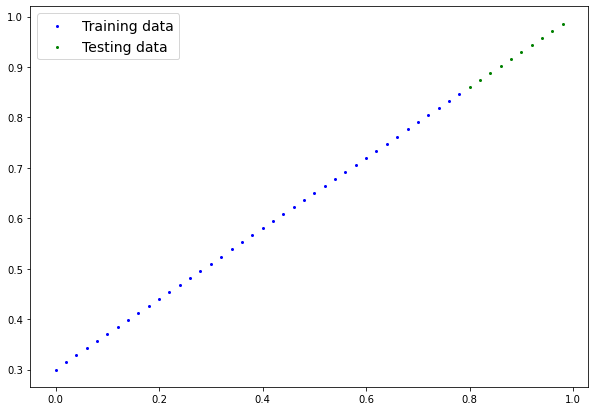

In [66]:
plot_predictions(X_train, y_train, X_test, y_test)

### TK - Building a model

* This time use `nn.Linear()`

In [67]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, 
                                      out_features=1)
    
    def forward(self, x):
        return self.linear_layer(x)

torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

### TK - Training

In [68]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

If model is on GPU, data has to be on GPU... 

In [70]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [71]:
torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
    # Without this, error will happen (not all model/data on device)
    X_train = X_train.to(device)
    X_test = X_test.to(device)
    y_train = y_train.to(device)
    y_test = y_test.to(device)

    # Training
    model_1.train() # train mode is on by default after construction
    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    # Testing
    model_1.eval()
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)
    
        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


In [72]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [73]:
weight, bias

(0.7, 0.3)

### TK - Making predictions

In [75]:
model_1.eval()
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

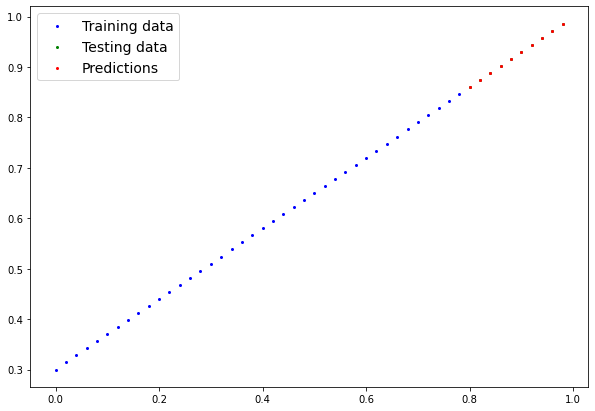

In [77]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU
plot_predictions(predictions=y_preds.cpu())

TK - you're going to get different values whether the model was computed on CPU and or GPU

### TK - Saving and loading a model

In [79]:
# Save model
os.makedirs("models", exist_ok=True)
save_path = "models/01_pytorch_workflow_model_1.pth"
torch.save(model_1.state_dict(), save_path)

In [80]:
# Load model (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1 = LinearRegressionModelV2()
loaded_model_1.load_state_dict(torch.load(save_path))
loaded_model_1.to(device)
loaded_model_1, next(loaded_model_1.parameters()).device

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 device(type='cuda', index=0))

In [81]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Extra-curriculum
* https://pytorch.org/tutorials/beginner/saving_loading_models.html